In [1]:
##Importing libraries
import cv2
import pickle
import joblib 
import numpy as np
import string
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda,Bidirectional
from keras.models import Model, Sequential, load_model
import keras.backend as K
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\AASHISH\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv("trainVal.csv")  ##Reading CSV file
df.head()

,track_id,image_path,lp,train
0,./crop_m1/I00000.png,./crop_m1/I00000.png,9B52145,0
1,./crop_m1/I00000.png,./crop_h1/I00000.png,9B52145,0
2,./crop_m1/I00001.png,./crop_m1/I00001.png,6B94558,0
3,./crop_m1/I00001.png,./crop_h1/I00001.png,6B94558,0
4,./crop_m1/I00002.png,./crop_m1/I00002.png,8B90164,0


##### From CSV file, taking track_id and lp columns for getting the image

In [3]:
## Char_list contains the combination of alphabets and digits

char_list = string.ascii_letters+string.digits

# print(char_list) 

def encode_to_labels(txt):
    # encoding each label into number
    '''
    for example : a:0,b:1,c:2 and word is "abac", then after passing from encode_to_label
    it become [0102] . 
    
    '''
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst  ##output of dig_lst random example [58, 27, 61, 56, 57, 57, 60]

In [4]:
'''
DATA PREPROCESSING

1. splitting the image and label into trainging and testing

   There are total 652 images. After splitting, 521 training image and 131 testing image

2. Resize the image to width = 128 and height = 32 so that every image is of fixed size and can pass into the model.

'''
# lists for training dataset
training_img = [] 
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
 
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

max_label_len = 0
for imagepath in range(len(df)):
    label = df['lp'][imagepath]
#     print(imagepath)
    
    img = df['track_id'][imagepath][2:]
    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY) 
    img = cv2.resize(img, (128,32))
    
   

    
    if len(label) > max_label_len:
        max_label_len = len(label)
            

    if imagepath%5 == 0:     
        valid_orig_txt.append(label)   
        valid_label_length.append(len(label)) #for CTC function
        valid_input_length.append(31) #for CTC function
        valid_img.append(img)
        valid_txt.append(encode_to_labels(label))
    else:
        orig_txt.append(label)   
        train_label_length.append(len(label)) #for CTC function
        train_input_length.append(31) #for CTC function
        training_img.append(img)
        training_txt.append(encode_to_labels(label)) 

In [5]:
len(orig_txt)

521

In [6]:
len(valid_img)

131

In [7]:
## padding is used so that everyu label is of fixed size, to prevent invariable label

train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [8]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs) #convolution layer 1
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)# poolig layer with kernel size (2,2)
 
conv_2 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_1)#convolution layer 2
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)#convolution layer 3
batch_norm_1 = BatchNormalization()(conv_3)
 
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_1)#convolution layer 4
batch_norm_2 = BatchNormalization()(conv_4)# Batch normalization layer
 
conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_2)#convolution layer 5
batch_norm_3 = BatchNormalization()(conv_5)# Batch normalization layer
pool_3 = MaxPool2D(pool_size=(3, 1))(batch_norm_3)
 
conv_6 = Conv2D(64, (2,2), activation = 'relu')(pool_3)#convolution layer 6
 
squeezed_layer = Lambda(lambda x: K.squeeze(x, 1))(conv_6)
 
# bidirectional LSTM layers with units = 128 and 64
blstm_layer_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed_layer)
blstm_layer_2 = Bidirectional(LSTM(64, return_sequences=True,dropout = 0.2))(blstm_layer_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_layer_2)

act_model = Model(inputs, outputs)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
act_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 32, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 64)         36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 32, 64)         256       
__________

In [10]:
'''
Defining Loss function

I have used CTC loss funtion for recognizing license plate. CTC overcome the problem of sequence generation.
Secondly, It take care of multiple time steps. for example, word is texture 
and RNN model predits ['t','e','e','x','t','t','u','r','e'].so, to predict the output, we need to merge the character
adjacent to each other. But this can also predict the word ['text'] which is wrong.so CTC take care of this things.Basically,
it place blank between the predicted output ['t','e','e','x','-','t','t','u','r','e'] and then merge and can predict correctly.


So CTC take 4 inputs:

1. y_true: your ground truth data. The data you are going to compare with the model's outputs in training. 
2. y_pred: is the model's calculated output
3. input_length:the length (in steps, or chars) of each sample (sentence) in the y_pred tensor.
4. label_length:the length (in steps, or chars ) of each sample (sentence) in the y_true (or labels) tensor.

''' 

labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
def ctc_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [11]:
'''
Now i compile the model with RMSPROP optimizer with learning_rate = 0.001, and save the weights in "my_model.h5" on the 
basis of validation loss.

'''

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizers.RMSprop(lr=0.001))
 
filepath="my_model.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [12]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [13]:
training_img=training_img.reshape(521, 32, 128,1)
valid_img = valid_img.reshape(131, 32, 128,1)

In [15]:
epochs = 100
batch_size = 16
model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 521 samples, validate on 131 samples
Epoch 1/100
521/521 [==============================] - 21s 40ms/step - loss: 25.9623 - val_loss: 20.3629

Epoch 00001: val_loss improved from inf to 20.36287, saving model to keras_model.pkl
Epoch 2/100
521/521 [==============================] - 16s 31ms/step - loss: 19.2434 - val_loss: 29.0273

Epoch 00002: val_loss did not improve from 20.36287
Epoch 3/100
521/521 [==============================] - 17s 32ms/step - loss: 18.1530 - val_loss: 18.6307

Epoch 00003: val_loss improved from 20.36287 to 18.63070, saving model to keras_model.pkl
Epoch 4/100
521/521 [==============================] - 15s 28ms/step - loss: 17.6780 - val_loss: 22.7091

Epoch 00004: val_loss did not improve from 18.63070
Epoch 5/100
521/521 [==============================] - 15s 29ms/step - loss: 17.5434 - val_loss: 17.7970

Epoch 00005: val_loss improved from 18.63070 to 17.79695, saving mo

521/521 [==============================] - 17s 33ms/step - loss: 2.4086 - val_loss: 3.1479

Epoch 00045: val_loss improved from 3.48714 to 3.14787, saving model to keras_model.pkl
Epoch 46/100
521/521 [==============================] - 16s 31ms/step - loss: 2.0645 - val_loss: 4.9499

Epoch 00046: val_loss did not improve from 3.14787
Epoch 47/100
521/521 [==============================] - 16s 32ms/step - loss: 2.0587 - val_loss: 2.4299

Epoch 00047: val_loss improved from 3.14787 to 2.42995, saving model to keras_model.pkl
Epoch 48/100
521/521 [==============================] - 18s 34ms/step - loss: 2.0200 - val_loss: 2.0445

Epoch 00048: val_loss improved from 2.42995 to 2.04450, saving model to keras_model.pkl
Epoch 49/100
521/521 [==============================] - 18s 35ms/step - loss: 1.6323 - val_loss: 2.1368

Epoch 00049: val_loss did not improve from 2.04450
Epoch 50/100
521/521 [==============================] - 18s 34ms/step - loss: 1.6363 - val_loss: 2.1188

Epoch 00050: val_

521/521 [==============================] - 15s 29ms/step - loss: 0.3123 - val_loss: 0.2111

Epoch 00095: val_loss did not improve from 0.11774
Epoch 96/100
521/521 [==============================] - 16s 30ms/step - loss: 0.3967 - val_loss: 0.4874

Epoch 00096: val_loss did not improve from 0.11774
Epoch 97/100
521/521 [==============================] - 15s 30ms/step - loss: 0.3167 - val_loss: 0.4946

Epoch 00097: val_loss did not improve from 0.11774
Epoch 98/100
521/521 [==============================] - 16s 30ms/step - loss: 0.4184 - val_loss: 0.0674

Epoch 00098: val_loss improved from 0.11774 to 0.06741, saving model to keras_model.pkl
Epoch 99/100
521/521 [==============================] - 16s 31ms/step - loss: 0.2372 - val_loss: 0.4926

Epoch 00099: val_loss did not improve from 0.06741
Epoch 100/100
521/521 [==============================] - 15s 29ms/step - loss: 0.3386 - val_loss: 0.3001

Epoch 00100: val_loss did not improve from 0.06741


In [35]:
# act_model.load_weights('my_model.h5')

original_text =  1B85815
predicted text = 1B85815



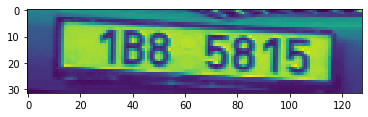

In [16]:
'''
In CTC decoder, it removes the duplicates character (inserting blank) and also take the highest probability 
of the character in each step.

'''

# load the saved best model weights
# act_model = joblib.load('keras_model.pkl')  
# act_model = load_model('keras_model.pkl')
# act_model = load_model('keras_model.pkl', compile=False)

act_model.load_weights('my_model.h5')
im = '1B85815.jpg'   #path of test image

img = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (128,32)) #resizing
plt.imshow(img)
plt.show

prediction = act_model.predict(img.reshape(1,32, 128, 1)) #reshaping the img to pass in model
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=False)[0][0])
 
# see the results

for x in out:
    print("original_text = ",im.split('.')[0])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')